### Insights from Failed Orders

Gett, previously known as GetTaxi, is an Israeli-developed technology platform solely focused on corporate Ground Transportation Management (GTM). They have an application where clients can order taxis, and drivers can accept their rides (offers). At the moment, when the client clicks the Order button in the application, the matching system searches for the most relevant drivers and offers them the order. In this task, we would like to investigate some matching metrics for orders that did not completed successfully, i.e., the customer didn't end up getting a car.

In [87]:
# importing necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [88]:
#load data_offers.csv
data_offers = pd.read_csv('data_offers.csv')
data_offers.head(5)

,order_gk,offer_id
0,3000579625629,300050936206
1,3000627306450,300052064651
2,3000632920686,300052408812
3,3000632771725,300052393030
4,3000583467642,300051001196


In [89]:
#load data_orders.csv
data_orders = pd.read_csv('data_orders.csv')
data_orders.head(5)

,order_datetime,origin_longitude,origin_latitude,m_order_eta,order_gk,order_status_key,is_driver_assigned_key,cancellations_time_in_seconds
0,18:08:07,-0.978916,51.456173,60.0,3000583041974,4,1,198.0
1,20:57:32,-0.950385,51.456843,NaN,3000583116437,4,0,128.0
2,12:07:50,-0.969520,51.455544,477.0,3000582891479,4,1,46.0
3,13:50:20,-1.054671,51.460544,658.0,3000582941169,4,1,62.0
4,21:24:45,-0.967605,51.458236,NaN,3000583140877,9,0,NaN


This two dataset has one common column 'order-gk'. We can combine it based on this column

In [90]:
df = pd.merge(data_orders,data_offers,on='order_gk')
df.head(5)

,order_datetime,origin_longitude,origin_latitude,m_order_eta,order_gk,order_status_key,is_driver_assigned_key,cancellations_time_in_seconds,offer_id
0,18:08:07,-0.978916,51.456173,60.0,3000583041974,4,1,198.0,300050983403
1,20:57:32,-0.950385,51.456843,NaN,3000583116437,4,0,128.0,300050986179
2,20:57:32,-0.950385,51.456843,NaN,3000583116437,4,0,128.0,300050986174
3,20:57:32,-0.950385,51.456843,NaN,3000583116437,4,0,128.0,300050986180
4,12:07:50,-0.969520,51.455544,477.0,3000582891479,4,1,46.0,300050976275


### Explore Dataset

In [91]:
#checking NaN values
nan_counts = df.isna().sum()
print(nan_counts)

order_datetime                       0
origin_longitude                     0
origin_latitude                      0
m_order_eta                      22904
order_gk                             0
order_status_key                     0
is_driver_assigned_key               0
cancellations_time_in_seconds     9473
offer_id                             0
dtype: int64


In [92]:
#checking data types
df.dtypes

order_datetime                    object
origin_longitude                 float64
origin_latitude                  float64
m_order_eta                      float64
order_gk                           int64
order_status_key                   int64
is_driver_assigned_key             int64
cancellations_time_in_seconds    float64
offer_id                           int64
dtype: object

In [93]:
df.shape

(31268, 9)

Question 1. Build up distribution of orders according to reasons for failure: cancellations before and after driver assignment, and reasons for order rejection. Analyse the resulting plot. Which category has the highest number of orders?

For this question, we need to consider: order_status_key(4 for cancel by client and 9 for cancel by system or reject),is_driver_assigned_key,order-number

In [94]:
df.groupby(by=['order_status_key','is_driver_assigned_key'])['order_gk'].count()

order_status_key  is_driver_assigned_key
4                 0                         13435
                  1                          8360
9                 0                          9469
                  1                             4
Name: order_gk, dtype: int64

Change the column values to understand easily

In [95]:
df = df.replace({'order_status_key': {4: 'Cancel by client', 9: 'Cancel by system'} })
df = df.replace({'is_driver_assigned_key': {1: 'Yes_Driver', 0: 'No_Driver '} })

In [96]:
df.groupby(by=['order_status_key','is_driver_assigned_key'])['order_gk'].count().reset_index(name='count')

,order_status_key,is_driver_assigned_key,count
0,Cancel by client,No_Driver,13435
1,Cancel by client,Yes_Driver,8360
2,Cancel by system,No_Driver,9469
3,Cancel by system,Yes_Driver,4


Now as this data types are categorical and we want to extract comparison among different classes, pivot can be used for better visualization

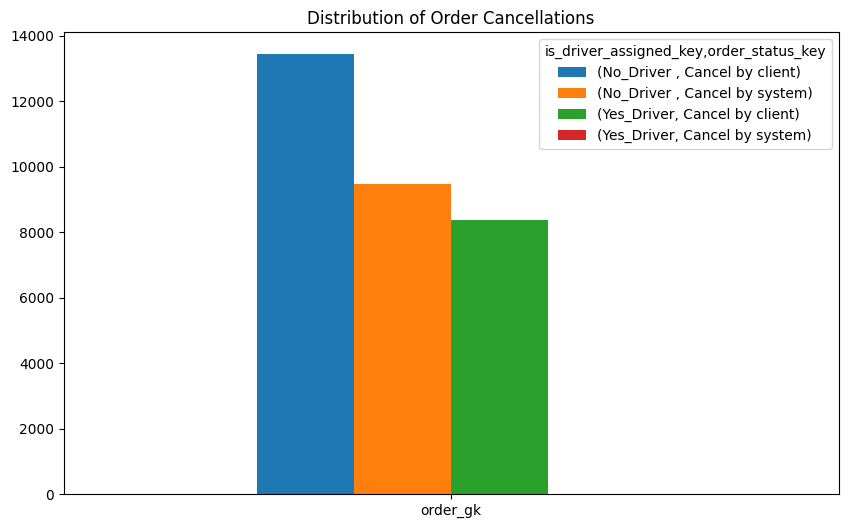

In [97]:
df_pivot = df.pivot_table(columns=["is_driver_assigned_key", "order_status_key"], values="order_gk", aggfunc="count")
ax = df_pivot.plot(kind='bar', figsize=(10, 6),legend=True)
# ax.set_xlabel('Order Status')
# ax.set_ylabel('Number of Orders')
ax.set_title('Distribution of Order Cancellations')
plt.xticks(rotation=0)  
plt.show()


1. Cancel by client before assigning driver is the highest category. I think this high number is due to high amount of time for getting driver. After waiting for a while, when the customers are not getting driver, they have cancelled the trip. 
2. Same is true for the second highest category when driver is not assigned and system cancelled the trip. As the system has not found any matching driver for a while, it has cancelled the trip
3. The third one is client cancelled the trip after driver assignment. This is probly the wait time for customer was long and customers have arranged another way as long as the driver assigned. I will analyse this reason with respect to m_order_eta column
4. On the other hand, cancel by system after assigning driver is the lowest category(only 4). It probably happened due to system error.

Further analyze the wait time for case 3

In [112]:
#filter rows where the order was cancelled by the client and driver was assigned 
canceled_orders = df[(df['order_status_key'] == 'Cancel by client') & (df['is_driver_assigned_key'] == 'Yes_Driver')]
# print(canceled_orders)

#calculate the count of these cancellations
canceled_count = canceled_orders.shape[0]

# calculate the wait time statistics for these cancelled orders
wait_time_canceled_orders = canceled_orders['m_order_eta']
wait_time_statistics = wait_time_canceled_orders.describe()

#output the results
canceled_count, wait_time_statistics

(8360,
 count    8360.000000
 mean      473.318780
 std       285.093468
 min        60.000000
 25%       238.000000
 50%       419.000000
 75%       658.000000
 max      1387.000000
 Name: m_order_eta, dtype: float64)

So, on average the wait time is 473 seconds when cancelled by client and driver assigned. I think many client has cancelled even after driver assignment because of this large wait time.

Question 2. Plot the distribution of failed orders by hours. Is there a trend that certain hours have an abnormally high proportion of one category or another? What hours are the biggest fails? How can this be explained?

For this question, order_datetime, order_gk and order_status_key columns are useful.

In [99]:
df.dtypes

order_datetime                    object
origin_longitude                 float64
origin_latitude                  float64
m_order_eta                      float64
order_gk                           int64
order_status_key                  object
is_driver_assigned_key            object
cancellations_time_in_seconds    float64
offer_id                           int64
dtype: object

In [100]:
#convert order_datetime column from object type to datetime type to extract hour value
import datetime
df['order_datetime'] = pd.to_datetime(df['order_datetime'])
df["hour"] = df["order_datetime"].dt.hour

C:\Users\swati\AppData\Local\Temp\ipykernel_5336\2748990148.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['order_datetime'] = pd.to_datetime(df['order_datetime'])


In [101]:
df.head(5)

,order_datetime,origin_longitude,origin_latitude,m_order_eta,order_gk,order_status_key,is_driver_assigned_key,cancellations_time_in_seconds,offer_id,hour
0,2024-07-14 18:08:07,-0.978916,51.456173,60.0,3000583041974,Cancel by client,Yes_Driver,198.0,300050983403,18
1,2024-07-14 20:57:32,-0.950385,51.456843,NaN,3000583116437,Cancel by client,No_Driver,128.0,300050986179,20
2,2024-07-14 20:57:32,-0.950385,51.456843,NaN,3000583116437,Cancel by client,No_Driver,128.0,300050986174,20
3,2024-07-14 20:57:32,-0.950385,51.456843,NaN,3000583116437,Cancel by client,No_Driver,128.0,300050986180,20
4,2024-07-14 12:07:50,-0.969520,51.455544,477.0,3000582891479,Cancel by client,Yes_Driver,46.0,300050976275,12


In [102]:
df_grouped = df.groupby(['hour', 'order_status_key']).size().reset_index(name='count')
df_grouped

,hour,order_status_key,count
0,0,Cancel by client,1283
1,0,Cancel by system,710
2,1,Cancel by client,931
3,1,Cancel by system,374
4,2,Cancel by client,826
5,2,Cancel by system,649
6,3,Cancel by client,760
7,3,Cancel by system,658
8,4,Cancel by client,182
9,4,Cancel by system,45


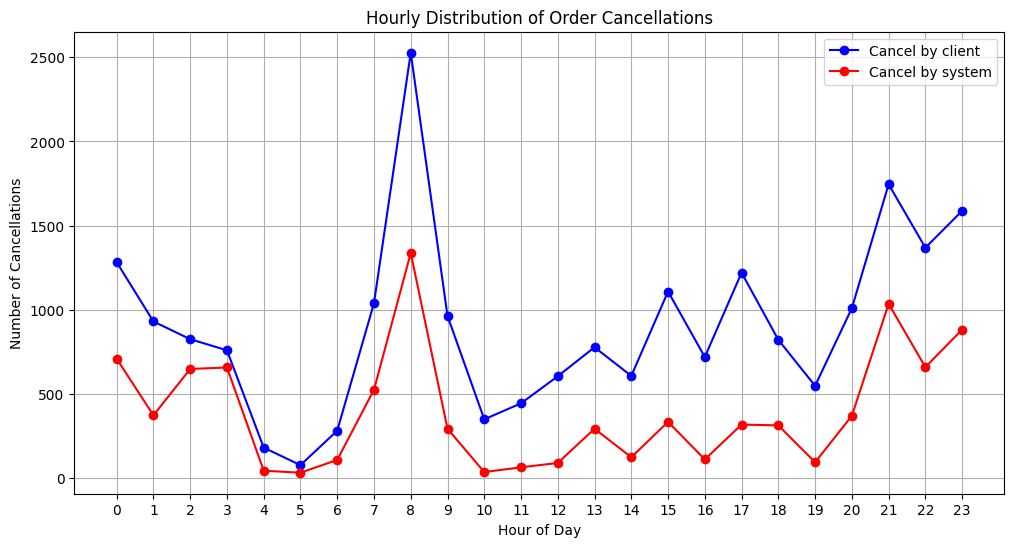

In [103]:
# split data for plotting
client_cancel = df_grouped[df_grouped['order_status_key'] == 'Cancel by client']
system_cancel = df_grouped[df_grouped['order_status_key'] == 'Cancel by system']

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(client_cancel['hour'], client_cancel['count'], label='Cancel by client', marker='o', color='blue')
plt.plot(system_cancel['hour'], system_cancel['count'], label='Cancel by system', marker='o', color='red')

plt.title('Hourly Distribution of Order Cancellations')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Cancellations')
plt.xticks(range(0, 24))
plt.grid(True)
plt.legend()
plt.show()

For both client and system order cancel have an abnormally high proportion at 8 a.m. I think this is a rush hour as it is a office time. So if the taxi delays for few time, customers are tend to cancel the trip. Also as this is busy hour, getting free taxi at nearby position in this time also difficult.

Question 3. Plot the average time to cancellation with and without driver, by the hour. If there are any outliers in the data, it would be better to remove them. Can we draw any conclusions from this plot?

For this question, We will consider cancellations_time_in_seconds and is_driver_assigned_key columns

In [104]:
df.dtypes

order_datetime                   datetime64[ns]
origin_longitude                        float64
origin_latitude                         float64
m_order_eta                             float64
order_gk                                  int64
order_status_key                         object
is_driver_assigned_key                   object
cancellations_time_in_seconds           float64
offer_id                                  int64
hour                                      int32
dtype: object

First figuring out if there is any outlier in the column 'cancellations_time_in_seconds' from a scatter plot

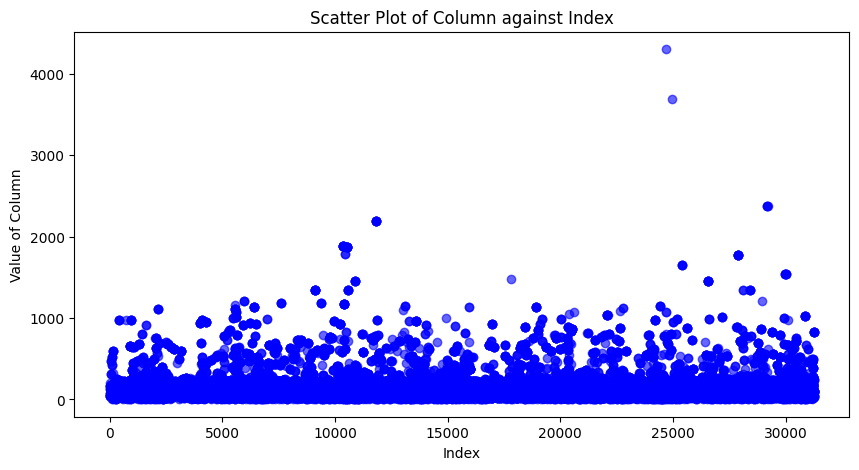

In [105]:
plt.figure(figsize=(10, 5))
plt.scatter(df.index, df['cancellations_time_in_seconds'], alpha=0.6, color='blue')  # Replace 'your_column_name' with your column's name
plt.title('Scatter Plot of Column against Index')
plt.xlabel('Index')
plt.ylabel('Value of Column')
plt.show()


So there are few outliers need to remove.

In [106]:
df.shape

(31268, 10)

In [107]:
df_filtered = df[(df['cancellations_time_in_seconds']<=3000)]
df_filtered.shape

(21793, 10)

In [108]:
df_grouped_avg = df_filtered.groupby(['hour','is_driver_assigned_key'])['cancellations_time_in_seconds'].mean().reset_index(name='avg')
df_grouped_avg

,hour,is_driver_assigned_key,avg
0,0,No_Driver,115.126437
1,0,Yes_Driver,276.082822
2,1,No_Driver,100.593997
3,1,Yes_Driver,296.312081
4,2,No_Driver,121.305461
5,2,Yes_Driver,301.466667
6,3,No_Driver,129.182301
7,3,Yes_Driver,368.682051
8,4,No_Driver,100.733333
9,4,Yes_Driver,245.250000


In [109]:
print(df_grouped_avg['is_driver_assigned_key'].unique())


['No_Driver ' 'Yes_Driver']


In [110]:
print(df_grouped_avg.head())

   hour is_driver_assigned_key         avg
0     0             No_Driver   115.126437
1     0             Yes_Driver  276.082822
2     1             No_Driver   100.593997
3     1             Yes_Driver  296.312081
4     2             No_Driver   121.305461


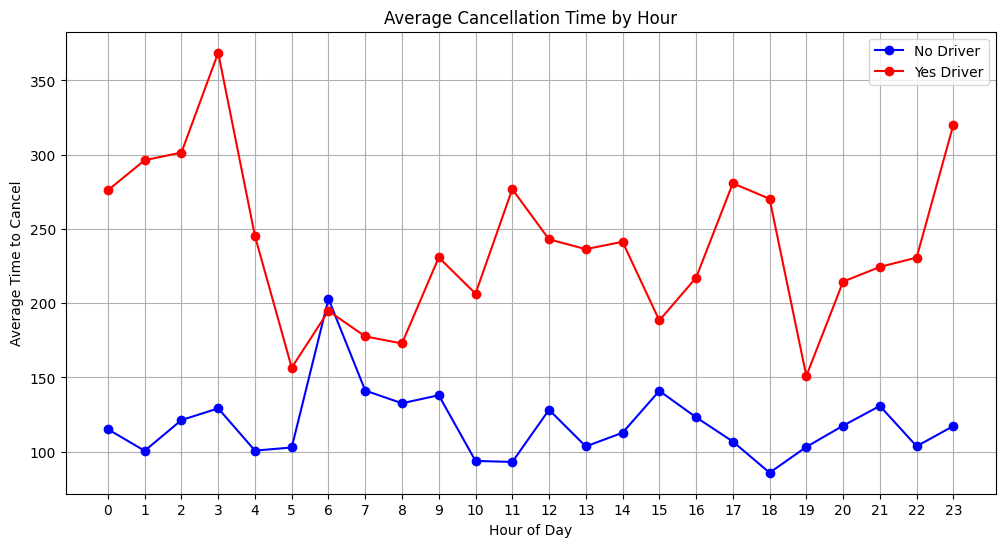

In [111]:
#split data for plotting based on driver assignment key
no_driver = df_grouped_avg[df_grouped_avg['is_driver_assigned_key'].str.strip() == 'No_Driver']
yes_driver = df_grouped_avg[df_grouped_avg['is_driver_assigned_key'].str.strip() == 'Yes_Driver']

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(no_driver['hour'], no_driver['avg'], label='No Driver', marker='o', color='blue')
plt.plot(yes_driver['hour'], yes_driver['avg'], label='Yes Driver', marker='o', color='red')

plt.title('Average Cancellation Time by Hour')
plt.xlabel('Hour of Day')
plt.ylabel('Average Time to Cancel')
plt.xticks(range(0, 24))
plt.grid(True)
plt.legend()
plt.show()

The average time of cancellation at 3 a.m. is higher with driver. This indiactes that at midnight there may be a scarcity of driver that takes a long time to assign driver and results high average of cancellation. On the other hand, average time of cancel without driver is higher at 6 a.m.

Question 4. Plot the distribution of average ETA by hours. How can this plot be explained?

In [26]:
df['m_order_eta'].head(5)

0     60.0
1      NaN
2      NaN
3      NaN
4    477.0
Name: m_order_eta, dtype: float64

For m_order_eta column, there are manu NaN values. I have calculated average wait time for each hour that are not NaN and replaces the NaN values with corresponding average values.

In [80]:
#convert 'order_datetime' to datetime and extract hour
df['order_hour'] = pd.to_datetime(df['order_datetime'], format='%H:%M:%S').dt.hour
#calculate average wait time for each hour
hourly_avg_wait_time = df.groupby('order_hour')['m_order_eta'].mean()
#fill missing values in 'm_order_eta' with the hourly average wait time
df['m_order_eta'] = df.apply(
    lambda row: hourly_avg_wait_time[row['order_hour']] if pd.isnull(row['m_order_eta']) else row['m_order_eta'], 
    axis=1
)

In [81]:
df.head(15)

,order_datetime,origin_longitude,origin_latitude,m_order_eta,order_gk,order_status_key,is_driver_assigned_key,cancellations_time_in_seconds,offer_id,order_hour
0,18:08:07,-0.978916,51.456173,60.000000,3000583041974,Cancel by client,Yes_Driver,198.0,300050983403,18
1,20:57:32,-0.950385,51.456843,299.627168,3000583116437,Cancel by client,No_Driver,128.0,300050986179,20
2,20:57:32,-0.950385,51.456843,299.627168,3000583116437,Cancel by client,No_Driver,128.0,300050986174,20
3,20:57:32,-0.950385,51.456843,299.627168,3000583116437,Cancel by client,No_Driver,128.0,300050986180,20
4,12:07:50,-0.969520,51.455544,477.000000,3000582891479,Cancel by client,Yes_Driver,46.0,300050976275,12
5,12:07:50,-0.969520,51.455544,477.000000,3000582891479,Cancel by client,Yes_Driver,46.0,300050976284,12
6,12:07:50,-0.969520,51.455544,477.000000,3000582891479,Cancel by client,Yes_Driver,46.0,300050976283,12
7,12:07:50,-0.969520,51.455544,477.000000,3000582891479,Cancel by client,Yes_Driver,46.0,300050976271,12
8,12:07:50,-0.969520,51.455544,477.000000,3000582891479,Cancel by client,Yes_Driver,46.0,300050976274,12
9,12:07:50,-0.969520,51.455544,477.000000,3000582891479,Cancel by client,Yes_Driver,46.0,300050976278,12


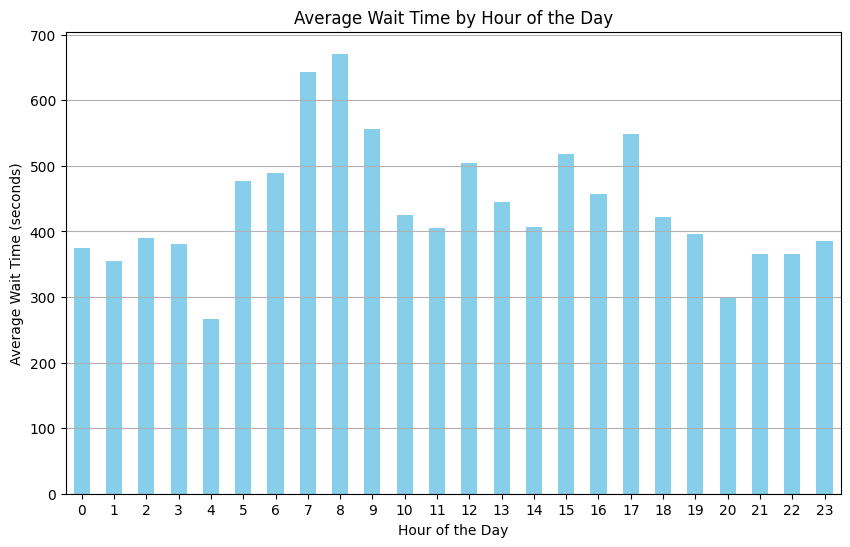

In [82]:
avg_eta_by_hour = df.groupby('order_hour')['m_order_eta'].mean()

# Plotting the average ETA by hour
plt.figure(figsize=(10, 6))
hourly_avg_wait_time.plot(kind='bar', color='skyblue')
plt.xlabel('Hour of the Day')
plt.ylabel('Average Wait Time (seconds)')
plt.title('Average Wait Time by Hour of the Day')
plt.xticks(rotation=0)
plt.grid(axis='y')

# Display the plot
plt.show()


From this plot, we can see that average time is high at 8 am. It is reasonable because previously in the plot of Question 2, we have seen that this time has highest cancel by client value without driver assignment.

Question 5: BONUS Hexagons. Using the h3 and folium packages, calculate how many sizes 8 hexes contain 80% of all orders from the original data sets and visualise the hexes, colouring them by the number of fails on the map.

In [39]:
import h3
import folium

In [41]:
df["hex_id"] = df.apply(
    func=lambda row: h3.geo_to_h3(lat=row["origin_latitude"], lng=row["origin_longitude"], resolution=8), axis=1)

In [42]:
df_hex = df.groupby(['hex_id'])['order_gk'].count().reset_index(name='count_order_gk')

In [43]:
df_hex.head(10)

,hex_id,count_order_gk
0,88195d2801fffff,65
1,88195d2803fffff,14
2,88195d2805fffff,10
3,88195d2807fffff,3
4,88195d2809fffff,46
5,88195d280bfffff,15
6,88195d280dfffff,117
7,88195d281dfffff,7
8,88195d2821fffff,3
9,88195d2823fffff,11


In [47]:
df_hex = df_hex.sort_values(by="count_order_gk")
total_orders = df_hex["count_order_gk"].sum()
df_hex["cum_sum"] = df_hex["count_order_gk"].cumsum()
df_hex["cum_perc"] = 200*df_hex["cum_sum"]/total_orders
df_hex[df_hex["cum_perc"]<=80]

,hex_id,count_order_gk,cum_sum,cum_perc
137,88195d74d5fffff,1,1,0.006396
135,88195d74d1fffff,1,2,0.012793
79,88195d2aebfffff,1,3,0.019189
11,88195d282bfffff,1,4,0.025585
122,88195d3993fffff,1,5,0.031982
...,...,...,...,...
23,88195d2861fffff,511,9295,59.453755
104,88195d2b39fffff,559,9854,63.029295
90,88195d2b17fffff,588,10442,66.790329
82,88195d2b03fffff,751,11193,71.593962


In [48]:
map = folium.Map(location=[df["origin_latitude"].mean(), df["origin_longitude"].mean()],
                 zoom_start=8.5,  # after a bit of experimentation, we thought this presents the map best
                 tiles="cartodbpositron")

In [51]:
import json
import geojson


def to_geojson(row):
    """Transform hex_id into a geojson object."""
    geometry = {
        "type": "Polygon",
        "coordinates": [h3.h3_to_geo_boundary(h=row["hex_id"], geo_json=True)]
    }
    return geojson.Feature(id=row["hex_id"], geometry=geometry, properties={"count_order_gk": row["count_order_gk"]})


geojsons = df_hex.apply(func=to_geojson, axis=1).values.tolist()
geojson_str: str = json.dumps(geojson.FeatureCollection(geojsons))

In [52]:
import matplotlib

# instantiate a colormap object for better visualisation
colormap = matplotlib.cm.get_cmap(name="plasma")
max_order_gk = df_hex["count_order_gk"].max()
min_order_gk = df_hex["count_order_gk"].min()

C:\Users\swati\AppData\Local\Temp\ipykernel_5336\4269884665.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap = matplotlib.cm.get_cmap(name="plasma")


In [53]:
_ = folium.GeoJson(data=geojson_str, style_function=lambda f: {
    "fillColor": matplotlib.colors.to_hex(
        colormap((f["properties"]["count_order_gk"] - min_order_gk) / (max_order_gk - min_order_gk))),
    "color": "black",
    "weight": 1,
    "fillOpacity": 0.7
}).add_to(map)

In [54]:
map

1. each hexagon on the map presents an area covered by a hex ID
2. Yellow hexagon represents highest count of 'order_gk'
3. Dark purple represents lower count of 'order_gk' 